In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import ranksums, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from tqdm.notebook import tqdm
import itertools

In [2]:
plt.rcParams["font.family"] = "Arial" 
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["svg.fonttype"] = "none"

def stat_annot_h(ax, x1, x2, y, h, color="k", text=r"$\ast$"):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color, clip_on=False)
    ax.text((x1+x2)*.5, y+h, text, ha='center', va='bottom', color=color, clip_on=False)

In [3]:
preproceeed_data_path = "../dataset/Nakano_etal_2010/preprocessed_data"
df = pd.read_csv(f"{preproceeed_data_path}/eyeclip_annotation.csv")

In [4]:
df

,clip_index,clip_name,start_index,end_index,start_resampled_index,end_resampled_index,object_name,object_id,subj,obj,eye,mouth,nose,ear,face,hand
0,1,しょうこゆうぞう_opening,1,140,0,233,Left しょうこ right eye,0,1,0,1,0,0,0,1,0
1,1,しょうこゆうぞう_opening,1,140,0,233,Left しょうこ left eye,1,1,0,2,0,0,0,1,0
2,1,しょうこゆうぞう_opening,1,140,0,233,Left しょうこ mouth,2,1,0,0,1,0,0,1,0
3,1,しょうこゆうぞう_opening,1,140,0,233,Left しょうこ right hand,3,1,0,0,0,0,0,0,1
4,1,しょうこゆうぞう_opening,1,140,0,233,Left ゆうぞう right eye,4,2,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,12,ざくろみたい,2183,2326,3641,3882,Girl1 left eye,5,2,0,2,0,0,0,1,0
126,12,ざくろみたい,2183,2326,3641,3882,Girl1 mouth,6,2,0,0,1,0,0,1,0
127,12,ざくろみたい,2183,2326,3641,3882,Girl2 right eye,7,1,0,1,0,0,0,1,0
128,12,ざくろみたい,2183,2326,3641,3882,Girl2 left eye,8,1,0,2,0,0,0,1,0


In [5]:
clip_indices = np.array([3,7,11])
cont = 0
for clip_idx in clip_indices:
    df_clip = df[df["clip_index"] == (clip_idx)].reset_index()
    sidx = df_clip["start_index"].unique()[0]
    eidx = df_clip["end_index"].unique()[0]
    cont += eidx-sidx
print(cont)

571


Gaze weightを読み込み

In [6]:
gazew_parts_subj_data = np.load("../results/gazew_parts_goodsubj_N2010.npz", allow_pickle=True)
gazew_parts_vit_data = np.load("../results/gazew_parts_vit_N2010.npz", allow_pickle=True)
gazew_parts_gbvs_data = np.load("../results/gazew_parts_gbvs_N2010.npz", allow_pickle=True)

In [7]:
gazew_parts_vit_data["gazew_parts"].item().keys()

dict_keys(['dino', 'supervised', 'dino_deit_small16', 'supervised_deit_small16'])

書き直し
- 色変更
- MDS best headの結果追加，分けて表示
- 統計検定
- GBVS追加

### participants

In [8]:
object_labels = gazew_parts_subj_data["object_labels"]
gr_keys = gazew_parts_subj_data["gr_keys"]

In [9]:
object_labels 

array(['obj', 'eye', 'mouth', 'nose', 'ear', 'face', 'hand'], dtype='<U5')

In [10]:
gazew_parts_subj = gazew_parts_subj_data['gazew_parts'].item()

In [11]:
clip_indices = np.array([3,7,11]) - 1 

In [12]:
gr_keys_rename ={'adult control': 'TD adults', 'child control': 'TD children',
                 'adult autistic': 'ASD adults', 'child autistic': 'ASD children'}

In [13]:
gazew_parts_subj_means = {}
for obj_idx, obj_label in enumerate(object_labels):
    gazew_parts_subj_means[obj_label] = {}
    for key in gr_keys:
        rekey = gr_keys_rename[key]
        gazew_parts_subj_means[obj_label][rekey] = np.nanmean(gazew_parts_subj[key][:, clip_indices, obj_idx], axis=1)

/tmp/ipykernel_39898/2142695050.py:6: RuntimeWarning: Mean of empty slice
  gazew_parts_subj_means[obj_label][rekey] = np.nanmean(gazew_parts_subj[key][:, clip_indices, obj_idx], axis=1)


In [14]:
gazew_parts_subj_means.keys()

dict_keys(['obj', 'eye', 'mouth', 'nose', 'ear', 'face', 'hand'])

### ViT

In [15]:
training_methods = ["dino", "supervised"] 
depth_list = [4, 8, 12]
num_models = 6
num_heads = 6

In [16]:
gazew_parts_vit_means = {}
for tm in training_methods:
    gazew_parts_vit_means[tm] = {}
    for depth in depth_list:
        gazew_parts_vit_means[tm][str(depth)] = {}
        gazew_parts_vit_depth = gazew_parts_vit_data['gazew_parts'].item()[tm][str(depth)]
        for obj_idx, obj_label in enumerate(object_labels):
            gazew_parts_vit_depth_mean = np.nanmean(gazew_parts_vit_depth[:, :, :, clip_indices, obj_idx], axis=3)
            gazew_parts_vit_means[tm][str(depth)][obj_label] = gazew_parts_vit_depth_mean#.transpose(1, 0, 2).reshape(depth, -1)

    gazew_parts_vit_means[f'{tm}_deit_small16'] = {}
    gazew_parts_vit_key = gazew_parts_vit_data['gazew_parts'].item()[f'{tm}_deit_small16']
    for obj_idx, obj_label in enumerate(object_labels):
        gazew_parts_vit_depth_mean = np.nanmean(gazew_parts_vit_key[:, :, clip_indices, obj_idx], axis=2)
        gazew_parts_vit_means[f'{tm}_deit_small16'][obj_label] = gazew_parts_vit_depth_mean

/tmp/ipykernel_39898/1902115878.py:8: RuntimeWarning: Mean of empty slice
  gazew_parts_vit_depth_mean = np.nanmean(gazew_parts_vit_depth[:, :, :, clip_indices, obj_idx], axis=3)
/tmp/ipykernel_39898/1902115878.py:14: RuntimeWarning: Mean of empty slice
  gazew_parts_vit_depth_mean = np.nanmean(gazew_parts_vit_key[:, :, clip_indices, obj_idx], axis=2)


In [17]:
vit_mds_dist = np.load("../results/mds_dist_N2010_dim32.npz", allow_pickle=True)
mds_dist_dict = vit_mds_dist["mds_dist"].item()

In [18]:
head_GMM_label = np.load("../results/head_GMM_label.npz", allow_pickle=True)
layer_indices = head_GMM_label["layer_indices"].astype(int)
"""
label_rank = head_GMM_label["label_rank"].astype(int)
head_label = head_GMM_label["head_label"].astype(int)
head_label_proba = head_GMM_label["head_label_proba"]
num_groups = len(np.unique(label_rank))
"""
head_label = np.load("../results/attn_best_label_N2010.npy").astype(int).reshape(4, 6, 6)

In [19]:
gazew_parts_vit_bh_means = {}
for obj_idx, obj_label in enumerate(object_labels):
    gazew_parts_vit_bh_means[obj_label] = []

tm = training_methods[0]
for i, depth in enumerate(depth_list[1:]):
    d_indices = layer_indices[layer_indices[:, 0] == depth][:,1]
    for obj_idx, obj_label in enumerate(object_labels):
        gazew_parts_obj = gazew_parts_vit_means[tm][str(depth)][obj_label]
        for m_idx in range(num_models):
            for j, d_idx in enumerate(d_indices):
                ij = i * 2 + j
                for h_idx in range(num_heads):
                    hl = head_label[ij, m_idx, h_idx]
                    if hl == 1:
                        #if label_rank[hl] == 0:
                        gazew_parts_vit_bh_means[obj_label].append(gazew_parts_obj[m_idx, d_idx, h_idx])

### GBVS

In [20]:
gazew_parts_gbvs_means = {}
for obj_idx, obj_label in enumerate(object_labels):
    gazew_parts_mean = np.nanmean(gazew_parts_gbvs_data["gazew_parts"][:, clip_indices, obj_idx], axis=1)
    gazew_parts_gbvs_means[obj_label] = gazew_parts_mean

/tmp/ipykernel_39898/3327651648.py:3: RuntimeWarning: Mean of empty slice
  gazew_parts_mean = np.nanmean(gazew_parts_gbvs_data["gazew_parts"][:, clip_indices, obj_idx], axis=1)


### Dict to dataframe

In [21]:
df_columns = ["object_label", "group", "gazew"]
df_pre = []
# participants
for obj_idx, obj_label in enumerate(object_labels):
    for key in ['TD adults', 'TD children']:#, 'ASD adults', 'ASD children']:
        gwp = gazew_parts_subj_means[obj_label][key]
        for g in gwp:
            df_pre.append([obj_label, key, g])
# vit
for obj_idx, obj_label in enumerate(object_labels):
    gwp = gazew_parts_vit_bh_means[obj_label]
    for g in gwp:
        df_pre.append([obj_label, "DINO ViT (G1)", g])

"""
# GBVS
for obj_idx, obj_label in enumerate(object_labels):
    gwp = gazew_parts_gbvs_means[obj_label]
    for g in gwp:
        df_pre.append([obj_label, "GBVS", g])
"""

'\n# GBVS\nfor obj_idx, obj_label in enumerate(object_labels):\n    gwp = gazew_parts_gbvs_means[obj_label]\n    for g in gwp:\n        df_pre.append([obj_label, "GBVS", g])\n'

In [22]:
df_gazew = pd.DataFrame(df_pre, columns=df_columns)

In [23]:
df_gazew 

,object_label,group,gazew
0,obj,TD adults,NaN
1,obj,TD adults,NaN
2,obj,TD adults,NaN
3,obj,TD adults,NaN
4,obj,TD adults,NaN
...,...,...,...
527,hand,DINO ViT (G1),0.149647
528,hand,DINO ViT (G1),0.178115
529,hand,DINO ViT (G1),0.096208
530,hand,DINO ViT (G1),0.144425


In [24]:
num_class = [2, 1]
#num_class = [4, 3, 3, 1]
num_group = np.sum(num_class)
group_ids = np.hstack([np.repeat(i, num_class[i]) for i in range(len(num_class))])
group_pos = np.arange(num_group) + group_ids * 0.5

group_names = ['TD adults', 'TD children', "DINO ViT (G1)"]
#group_names = ['TD adults', 'TD children', 'ASD adults', 'ASD children']
#group_names += [f"{tm_}{depth}" for tm_ in ["DINO ViT-", "SL ViT-"] for depth in depth_list ]
#group_names += ["GBVS"]

group2num_dict = {}
for i in range(len(group_names)):
    group2num_dict[group_names[i]] = group_pos[i]

In [25]:
group_names

['TD adults', 'TD children', 'DINO ViT (G1)']

In [26]:
object_labels_part = ['eye', 'mouth', 'face'] #'mouth/face'] #, 'eye/face'
df_obj_num_dict = {}
for obj_label in object_labels_part:
    df_obj = df_gazew[df_gazew["object_label"] == obj_label]
    df_obj_num = df_obj.replace({'group': group2num_dict})
    df_obj_num_dict[obj_label] = df_obj_num

In [27]:
cmap_cb = sns.color_palette("colorblind")
#cmap = sns.color_palette("bright")
cmap = sns.color_palette("tab10")
#cmap = mpl.colormaps.get_cmap('tab10')

subj_colors = [cmap[3], cmap_cb[8], cmap[1], cmap[4]]
model_colors = [[cmap_cb[9] for j in range(3)], [cmap_cb[2] for j in range(3)], [cmap_cb[7]]]
"""
subj_labels = ["TD adults", "TD children", "ASD adults", "ASD children"]
subj_markers = ["o", "^", "o", "^"]
model_labels = [["DINO ViT-4", "DINO ViT-8", "DINO ViT-12"], ["SL ViT-4", "SL ViT-8", "SL ViT-12"]]
model_colors = [[cmap_cb[9] for j in range(3)], [cmap_cb[2] for j in range(3)], [cmap_cb[7]]]
color_list = subj_colors + list(itertools.chain.from_iterable(model_colors))
"""
model_markers = ["P", "s", "D"]
color_list = subj_colors[:2] + [model_colors[0][0]]
color_pal = {}
for i, key in enumerate(group_pos):
    color_pal[key] = color_list[i]

xo = np.arange(0, group_pos.max()+0.5, 0.5)

In [28]:
ymax = np.array([80, 60, 100])#, 90])
xgr = np.arange(len(gr_keys))

In [29]:
def delete_nan(arr):
    return arr[~np.isnan(arr)]

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [45]:
stat_test_dict = {}
for i, obj_label in enumerate(object_labels_part):
    stat_test_dict[obj_label] = {}
    df = df_gazew[df_gazew["object_label"] == obj_label]
    # get pair of groups
    pairs = []
    pairs_num = []
    n_col = len(group_names)
    for i in range(n_col):
        for j in range(1, n_col):
            if j > i:
                pairs.append((group_names[i], group_names[j]))
                pairs_num.append((i, j))

    # statistic test 
    p_values = []
    for pair in pairs:
        v1 = df[df["group"] == pair[0]]["gazew"].values
        v2 = df[df["group"] == pair[1]]["gazew"].values
        s, p = mannwhitneyu(v1, v2, method="exact", alternative="two-sided")
        p_values.append(p)

    # multiple test correction
    print(obj_label, p_values)
    reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha=0.05, method='bonferroni')
    print(obj_label, pvals_corrected)
    #reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha=0.05, method='fdr_bh')# method='bonferroni')
    #indices = [i for i, x in enumerate(reject) if x] # significance indices
    #sd_pairs = [pairs[i] for i in indices]
    #sd_pairs_num = [pairs_num[i] for i in indices]
    
    # save
    stat_test_dict[obj_label]["pvals"] = pvals_corrected#[indices]
    stat_test_dict[obj_label]["pairs"] = pairs
    stat_test_dict[obj_label]["pairs_num"] = pairs_num

eye [0.0008304967921156042, 0.93292696434883, 0.00196799157338513]
eye [0.00249149 1.         0.00590397]
mouth [0.0011878769887268496, 1.742221640445154e-14, 4.621634627531729e-06]
mouth [3.56363097e-03 5.22666492e-14 1.38649039e-05]
face [0.29924406721213964, 5.741839860415094e-10, 1.4239311484407506e-12]
face [8.97732202e-01 1.72255196e-09 4.27179345e-12]


In [37]:
for i, obj_label in enumerate(object_labels_part):
    df_obj_num = df_obj_num_dict[obj_label]
    print(obj_label, df_obj_num.groupby(['group'])[["gazew"]].median())

eye            gazew
group           
0.0    43.138857
1.0    26.356438
2.5    42.422678
mouth            gazew
group           
0.0    12.432138
1.0    19.224187
2.5    31.930642
face            gazew
group           
0.0    65.705272
1.0    66.202303
2.5    92.020091


In [42]:
obj_label = "eye"
stat_test_dict[obj_label]["pvals"], stat_test_dict[obj_label]["pairs"]

(array([0.00249149, 1.        , 0.00590397]),
 [('TD adults', 'TD children'),
  ('TD adults', 'DINO ViT (G1)'),
  ('TD children', 'DINO ViT (G1)')])

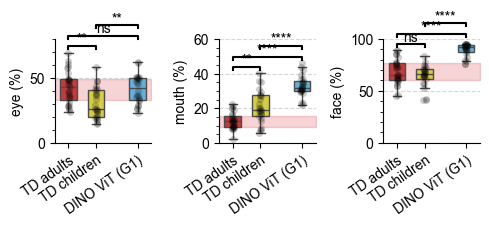

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(5, 2.5), sharex='col')
for i, obj_label in enumerate(object_labels_part):
    df_obj_num = df_obj_num_dict[obj_label]
    #sns.violinplot(data=df_obj_num, x="group", y="gazew", hue="group", palette=color_pal, 
    #                  ax=axes[i], order=xo, legend=False)
    sns.boxplot(data=df_obj_num, x="group", y="gazew", hue="group", palette=color_pal, 
                ax=axes[i], order=xo, 
                showfliers=False, legend=False, width=1.2)
    sns.stripplot(data=df_obj_num, x="group", y="gazew", color="k", 
                  alpha=0.2, ax=axes[i], rasterized=False)
    """
    axes[i].scatter([14.2]*5, gazew_parts_vit_bh_means['dino_deit_small16'][obj_label][::-1], 
                    fc="white", ec=model_colors[0][0],
                    marker="D", label="Official ViT-12", alpha=1, s=15)
    axes[i].scatter([21.2]*5, gazew_parts_vit_bh_means['supervised_deit_small16'][obj_label][::-1], 
                    fc="white", ec=model_colors[1][0], 
                    marker="D", label=" ",alpha=1, s=15)
    """
    axes[i].set_xticks(ticks=group_pos*2)
    axes[i].set_xticks(ticks=group_pos*2)
    axes[i].set_xticklabels(group_names, rotation=35, ha="right", rotation_mode='anchor')
    axes[i].set_xlim(-1, len(xo))
    axes[i].set_ylim(0, 100)
    td_ad = df_obj_num[df_obj_num["group"] == 0]["gazew"].values
    axes[i].fill_between([-1, len(xo)], 
                         np.percentile(td_ad, 25),
                         np.percentile(td_ad, 75),
                         color=color_list[0], alpha=0.2, label="TD adults IQR", zorder=-1)
    pvals_corrected = stat_test_dict[obj_label]["pvals"] #[indices]
    pairs = stat_test_dict[obj_label]["pairs"]
    pairs_num = stat_test_dict[obj_label]["pairs_num"]
    count = 0
    for j, pair in enumerate(pairs_num):
        x1, x2 = pair
        y = ymax[i] - 8
        if i == 1:
            y -= 10
        ratio = ymax[i]/100 
        h = 3*(ratio)
        text = convert_pvalue_to_asterisks(pvals_corrected[j])
        p = pvals_corrected[j]
        #if p > 0.05:
        stat_annot_h(axes[i], group_pos[x1]*2, group_pos[x2]*2, 
                     y+count*10*ratio, h, color="k", text=text)
        #stat_annot_h(axes[i], group_pos[x1]*2, group_pos[x2]*2, y+count*20, h, color="k", text=r"$p=$"+f"{p:.4f}")
        count += 1

    axes[i].grid(linestyle='--', alpha=0.5, axis='y')
    axes[i].set_ylabel(obj_label+" (%)")
    #ax.legend(ncol=2, handletextpad=0, columnspacing=1, prop={'size': 9}, labelspacing=0.1)
    axes[i].set_xlabel("")
    axes[i].set_ylim(0, ymax[i])
    #for i in range(len(mds_saliency)):
    #    ax.text(24, mds_saliency[i], saliency_labels[i], va="center", fontsize=9, rotation=35, rotation_mode='anchor')
    axes[i].minorticks_on()
    axes[i].xaxis.set_tick_params(which='minor', bottom=False)
fig.align_ylabels()
fig.tight_layout()
plt.savefig("../figures/keypoint_viewing_prop.svg", dpi=300, bbox_inches='tight')

In [33]:
best_head_indices_dict = {}
num_top = 5
for tm in training_methods:
    best_head_indices_dict[tm] = {}
    for depth in depth_list:
        model_mds_dist = mds_dist_dict[tm][str(depth)]
        #if depth == 12:
        #    model_mds_dist = np.concatenate([model_mds_dist, mds_dist_dict[f'{tm}_deit_small16'][None, :, :]])
        num_models = len(model_mds_dist)
        best_head_indices = np.zeros((num_models, num_top, 3))
        for i in range(num_models):
            model_mds_dist_min = np.sort(model_mds_dist[i].flatten())[:num_top]
            for j in range(num_top):
                model_indices = np.argwhere(model_mds_dist == model_mds_dist_min[j])
                best_head_indices[i, j] = model_indices[0]
        best_head_indices_dict[tm][str(depth)] = best_head_indices.astype(int)

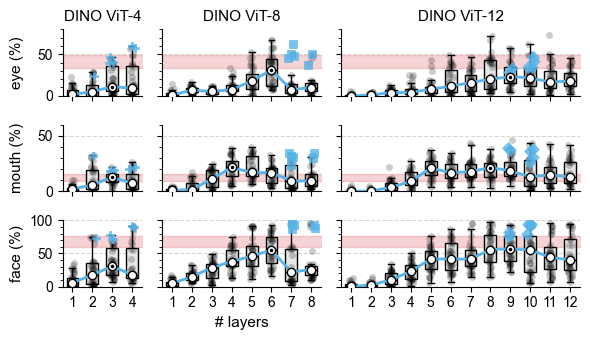

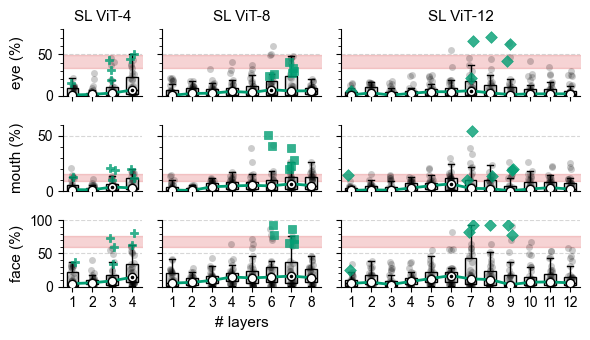

In [34]:
for midx, tm in enumerate(training_methods):
    fig, axes = plt.subplots(3, 3, figsize=(6, 3.5), sharex='col', 
                             sharey='row',width_ratios=[1, 2, 3], tight_layout=True)
    #fig.suptitle("All data")
    for i, obj_label in enumerate(object_labels_part):
        for j, depth in enumerate(depth_list):
            xs = np.arange(0, depth)
            gazew_tmp = gazew_parts_vit_means[tm][str(depth)][obj_label]
            best_head_indices = best_head_indices_dict[tm][str(depth)]
            gazew_bh = []
            for idx in best_head_indices[:, 0]:
                gazew_bh.append(gazew_tmp[idx[0], idx[1], idx[2]])
            columns = [str(d+1) for d in range(depth)]
            gazew_tmp_flat = gazew_tmp.transpose(1, 0, 2).reshape(depth, -1).T
            df = pd.DataFrame(gazew_tmp_flat, columns=columns)#, columns=np.array2string(np.arange(1, depth+1)))
            df_melt = df.melt()
            vit_min_indices = df_melt["value"].isin(gazew_bh)
            dist_median = np.median(gazew_tmp_flat, axis=0)
            dist_median_minidx = np.argmax(dist_median)  
            axes[i, j].scatter(dist_median_minidx, dist_median[dist_median_minidx], color="k", marker=".", s=10, zorder=11)
    
            sns.boxplot(data=df_melt, x="variable", y="value", showfliers=False, color="0.9", width=0.6, 
                        ax=axes[i, j], linecolor="k")
            #sns.boxplot(data=df_melt, x="variable", y="value", showfliers=False, color=model_colors[i][j], width=0.6, 
            #            ax=axes[i, j])
            axes[i, j].plot(np.arange(0, len(dist_median)), dist_median, color=model_colors[midx][0], 
                            linewidth = 2.0, marker="o", ms=6, mec="k", mfc="white", zorder=10)
            sns.stripplot(data=df_melt[~vit_min_indices], x="variable", y="value", color="k", alpha=0.2, ax=axes[i, j], rasterized=False)
            axes[i, j].scatter(df_melt[vit_min_indices]["variable"].to_numpy().astype(float) -1 + (np.random.rand(num_models)-0.5)/3, 
                               df_melt[vit_min_indices]["value"].to_numpy().astype(float), 
                               marker=model_markers[j], facecolor=model_colors[midx][0], linewidth=0.5, alpha=0.8, zorder=3, 
                               label="Model-best heads")
            """
            official_min_idx = np.where(mds_dist_dict[f"{tm}_deit_small16"] == mds_dist_min_dict[f"{tm}_deit_small16"])[0]
            if j == 2:
                axes[i, j].scatter(official_min_idx+0.3, mds_dist_min_dict[f"{tm}_deit_small16"], 
                                   ec=model_colors[i][j], fc="white", linewidth=0.5, marker="D", alpha=1, zorder=5, label="Official model-best heads")
            """
            axes[i, j].grid(linestyle='--', alpha=0.5, axis='y')
            axes[i, j].set_ylim(0, ymax[i])
            axes[i, j].set_xticks(xs) 
            axes[i, j].set_xticklabels(xs+1)
            axes[i, j].set_xlim(-0.5, depth-0.5)
            axes[i, j].minorticks_on()
            axes[i, j].xaxis.set_tick_params(which='minor', bottom=False)
            if tm == "dino":
                tm_ = "DINO ViT-"
            else:
                tm_ = "SL ViT-"
            if i == 0:
                axes[i, j].set_title(f"{tm_}{depth}", fontsize=11)
            if j == 0:
                axes[i, j].set_ylabel(obj_label+" (%)", fontsize=11)
            else:
                axes[i, j].set_ylabel("")
                
            df_obj_num = df_obj_num_dict[obj_label]
            td_ad = df_obj_num[df_obj_num["group"] == 0]["gazew"].values
            axes[i, j].fill_between([-1, depth], 
                                     np.percentile(td_ad, 25),
                                     np.percentile(td_ad, 75),
                                     color=color_list[0], alpha=0.2, label="TD adults IQR", zorder=-1)
            if j == 1:
                axes[-1, j].set_xlabel("# layers", fontsize=11)
            else:
                axes[-1, j].set_xlabel("")
    fig.align_ylabels()
    #fig.show()
    plt.savefig(f"../figures/keypoint_viewing_prop_layer_{tm}.svg", dpi=300, bbox_inches='tight')